# Customer Lifetime Value or CLV (Total profit derived from customer)
## Setting (Online Retail)- 
    1. Non-Contractual ("death" of customer unobserved) 
    2. Continuous Purchases ("non-periodicity" of purchases - can happen anytime)

### Importing libraries (and modules)

**Required lib(s)**

In [111]:
#Data manipulations
import pandas as pd  
import datetime as dt  

#Vizualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

#CLV library and modules
!pip install lifetimes
from lifetimes.plotting import *  #plotting functions (especific plots CLV related)
from lifetimes.utils import *   #utility functions (convert trans data to RFM matrix)
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter  #CLV Model



**Good-to-have**

In [68]:
import warnings
warnings.filterwarnings('ignore')

### Importing data and high-level inspection

**Imports**

In [43]:
#Importing file from the web into a Pandas DF
df=pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

**High-level Inspection**

In [94]:
#Checking a few rows from the top
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [98]:
#Getting info (rows, cols, datatypes)
print(df.info(),'\n')

#Getting some Summary Stats (including all cols types)
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


### Data Cleaning and Manipulations

**Cleaning - Character columns**

In [104]:
#Filtering - Removing rows where customer ID is NULL
df1=df[df['CustomerID'].notnull()]

**Cleaning - Numeric columns**

In [123]:
#Filtering - Removing rows where quantity and unit-price -ve => "returns"
##Note: Rows where unit price <=0 is (40); but for unit price <0 it's (zero)
##Note: Rows where quantity <=0 is (8905); and it's for quantity <0 
df2=df1[(df1['Quantity']>0)] 

**Cleaning - Datetime columns**

In [124]:
#Extracting dates out of datetime column
df2['InvoiceDate']=df2['InvoiceDate'].dt.date

**Manipulations - 1**

In [125]:
#Adding a required column for our model (i.e. Revenue)
df2['Revenue']=df2['UnitPrice']*df2['Quantity']

#Keeping only those columns that we need for analysis
df3=df2[['CustomerID','InvoiceDate','Revenue']]

#High-level inspection of our analytical data
print(df3.head(),'\n')
print(df3.info(), '\n')
print(df3.describe(include="all"))

   CustomerID InvoiceDate  Revenue
0     17850.0  2010-12-01    15.30
1     17850.0  2010-12-01    20.34
2     17850.0  2010-12-01    22.00
3     17850.0  2010-12-01    20.34
4     17850.0  2010-12-01    20.34 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 3 columns):
CustomerID     397924 non-null float64
InvoiceDate    397924 non-null object
Revenue        397924 non-null float64
dtypes: float64(2), object(1)
memory usage: 12.1+ MB
None 

           CustomerID InvoiceDate        Revenue
count   397924.000000      397924  397924.000000
unique            NaN         305            NaN
top               NaN  2011-11-06            NaN
freq              NaN        3423            NaN
mean     15294.315171         NaN      22.394749
std       1713.169877         NaN     309.055588
min      12346.000000         NaN       0.000000
25%      13969.000000         NaN       4.680000
50%      15159.000000         NaN      11.800000
75%      167

**Manipulations - 2**

In [120]:
#Creating the "lifetimes object" - freq, recency, T, monetary_value
##Note: freq - no. of repeated trans in obs period
##Note: recency - duration btwn first trans to recent trans
##Note: T - duration btwn first trans to end of obs period
df4=summary_data_from_transaction_data(transactions=df3,
                                       customer_id_col='CustomerID',
                                       datetime_col='InvoiceDate',
                                       monetary_value_col='Revenue',
                                       observation_period_end='2011-12-9')

#High-level inspection of our final analytical data
print(df4.head(),'\n')
print(df4.info(), '\n')
print(df4.describe(include="all"))

            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           0.0      0.0  325.0        0.000000
12347.0           6.0    365.0  367.0      599.701667
12348.0           3.0    283.0  358.0      301.480000
12349.0           0.0      0.0   18.0        0.000000
12350.0           0.0      0.0  310.0        0.000000 

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
frequency         4339 non-null float64
recency           4339 non-null float64
T                 4339 non-null float64
monetary_value    4339 non-null float64
dtypes: float64(4)
memory usage: 169.5 KB
None 

         frequency      recency            T  monetary_value
count  4339.000000  4339.000000  4339.000000     4339.000000
mean      2.864024   130.741415   222.782899      306.944168
std       5.952745   132.210176   117.883623     2612.453380
min       0.000000     0.000000     0.000000      

## EDA of analytical dataset

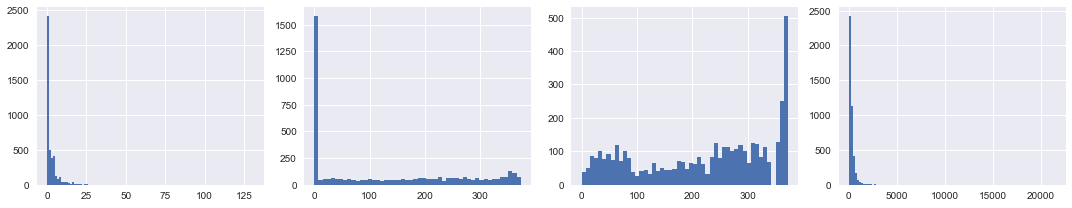

In [261]:
#Frequency distribution of variables (RFM)
fig,axes=plt.subplots(1,4, figsize=(15,3))
axes[0].hist(df4['frequency'],bins=100)
axes[1].hist(df4['recency'],bins=50)
axes[2].hist(df4['T'],bins=50)
axes[3].hist(df4[df4['monetary_value']<=50000]['monetary_value'],bins=100)
plt.tight_layout()

In [251]:
#Checking values with 0 value in ADS (These are one time buyers or non-repeat buyers)
print('% of customers with zero frequen', sum(df4['frequency']==0)/len(df4))
print('% of customers with zero recency', sum(df4['recency']==0)/len(df4))
print('% of customers with zero mon_val', sum(df4['monetary_value']==0)/len(df4))

% of customers with zero frequen 0.356994699239
% of customers with zero recency 0.356994699239
% of customers with zero mon_val 0.356994699239


## Fitting Models
    1. BG/NBD Model (for expected no. of purchases in next period)
    2. Gamma-Gamma Model (for expected money_value in next peirod)
    Note: Both models capture prob of survival in next period based on RF mat

**Fitting BG/NBD Model**

In [256]:
#1. Fitting BG/NBD Model to ADS
BG_NBD=BetaGeoFitter(penalizer_coef=0.0)
BG_NBD.fit(frequency=df4['frequency'], 
           recency=df4['recency'], 
           T=df4['T'])
print(BG_NBD)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.94, b: 2.01, r: 0.83>


**Visualising BG/NBD Model Outputs**
    1. Exp purchases next peirod
    2. Prob of survival nxt period
    Note: This model says best customers are those who make more # of purch and more recent purch 

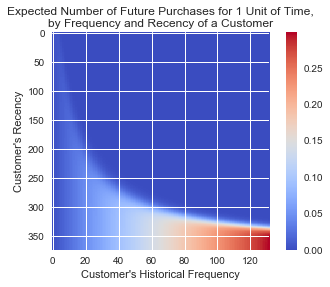

In [281]:
#Plot1: Expected No. of purchases per unit time w.r.t Freq, Rece
plot_frequency_recency_matrix(BG_NBD)

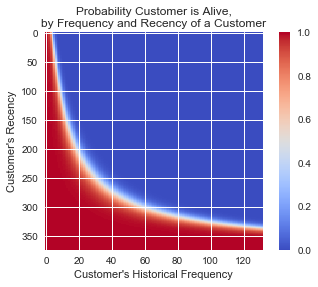

In [280]:
#Plot2: Prob of customer being alive w.r.t Freq, Rece
plot_probability_alive_matrix(BG_NBD)

** BG/NBD Model Predictions**

In [287]:
#Top 5 customers (in terms of exp no. of purchases)
t=90
df4['PredPurc_till_t']=BG_NBD.conditional_expected_number_of_purchases_up_to_time(t=t,frequency=df4['frequency'],recency=df4['recency'],T=df4['T'])
df4.sort_values(by='PredPurc_till_t').tail(5)

,frequency,recency,T,monetary_value,PredPurc_till_t
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,18.086994
15311.0,89.0,373.0,373.0,677.729438,18.290673
17841.0,111.0,372.0,373.0,364.452162,22.770336
12748.0,113.0,373.0,373.0,298.360885,23.177656
14911.0,131.0,372.0,373.0,1093.661679,26.842807


**Assessing BG/NBD Model Fit**

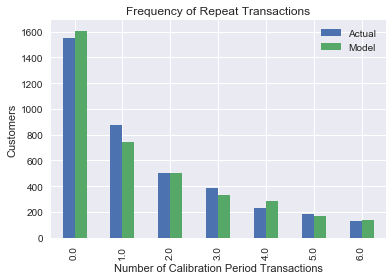

In [288]:
#Actual Vs. Pred repeat purch in calibration period
plot_period_transactions(BG_NBD)